# Example using PyMC3

Here's an example of using [PyMC3](http://docs.pymc.io/) to fit a linear model with a Gaussian likelihood. It's basically a copy of the example given [here](http://docs.pymc.io/notebooks/getting_started.html). 

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as pl
import pymc3 as pm

In [2]:
# set true gradient and y-intercept for a linear model
m = 3.5 # gradient
c = 1.2 # y-intercept

# set the "predictor variable"/abscissa
x = np.linspace(0., 10., 100) # 100 points linearly spaced between 0 and 10

# create some "data" - the model plus Gaussian noise
sigma = 0.4 # standard deviation of noise
y = m*x + c + np.random.randn(len(x))*sigma

In [3]:
# set the PyMC3 model
linear_model = pm.Model()

with linear_model:
    # set priors for unknown parameters
    mmodel = pm.Uniform('m', lower=-10., upper=10.) # uniform prior on gradient
    cmodel = pm.Uniform('c', lower=-10., upper=10.) # uniform prior on gradient
    
    sigmamodel = sigma # set a single standard deviation
    
    # Expected value of outcome, aka "the model"
    mu = mmodel*x + cmodel
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigmamodel, observed=y)

In [4]:
# perform sampling
with linear_model:
    start = pm.find_MAP()  # Find starting value by optimization
    trace = pm.sample(10000, start=start, tune=1000, discard_tuned_samples=True) # 10000 iterations, with 1000 iteration burn-in 

logp = -45.359, ||grad|| = 4.899: 100%|██████████| 15/15 [00:00<00:00, 1119.16it/s]  
100%|██████████| 11000/11000 [00:09<00:00, 1109.47it/s]


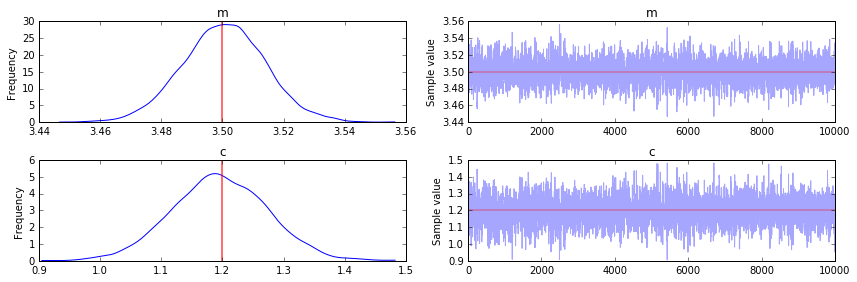

In [5]:
# plot trace output (overplot the true values)
_ = pm.traceplot(trace, lines={'m': m, 'c': c})

In [6]:
# set the PyMC3 model (this time have sigma as unknown)
linear_model_sigma = pm.Model()

with linear_model_sigma:
    # set priors for unknown parameters
    mmodel = pm.Uniform('m', lower=-10., upper=10.)         # uniform prior on gradient
    cmodel = pm.Normal('c', mu=0., sd=10.)                  # Gaussian prior on gradient
    sigmamodel = pm.Uniform('sigma', lower=0.01, upper=10.) # uniform prior on unknown standard deviation
    
    # Expected value of outcome, aka "the model"
    mu = mmodel*x + cmodel
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigmamodel, observed=y)

In [7]:
# perform sampling
with linear_model_sigma:
    start2 = pm.find_MAP()  # Find starting value by optimization
    trace2 = pm.sample(10000, start=start2, tune=1000, discard_tuned_samples=True) # 10000 iterations, with 1000 iteration burn-in 

logp = -54.458, ||grad|| = 1,283.7: 100%|██████████| 40/40 [00:00<00:00, 1681.32it/s]  
100%|██████████| 11000/11000 [00:13<00:00, 811.55it/s]


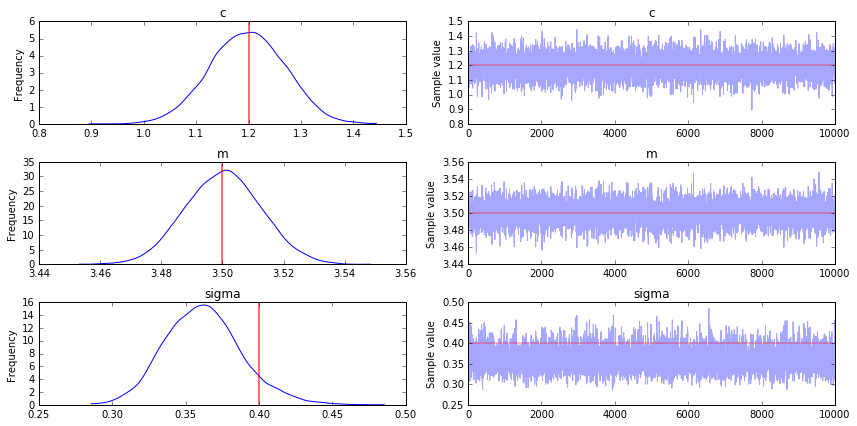

In [8]:
# plot trace output (overplot the true values)
_ = pm.traceplot(trace2, lines={'m': m, 'c': c, 'sigma': sigma})

In [9]:
# set the PyMC3 model (this time have sigma a value for each data point)
linear_model_sigma_many = pm.Model()

with linear_model_sigma_many:
    # set priors for unknown parameters
    mmodel = pm.Uniform('m', lower=-10., upper=10.)         # uniform prior on gradient
    cmodel = pm.Normal('c', mu=0., sd=10.)                  # Gaussian prior on gradient
    
    sigmamodel = np.ones(len(y))*sigma # a set of known standard deviations for each data point
    
    # Expected value of outcome, aka "the model"
    mu = mmodel*x + cmodel
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigmamodel, observed=y)

In [10]:
# perform sampling
with linear_model_sigma_many:
    start3 = pm.find_MAP()  # Find starting value by optimization
    trace3 = pm.sample(10000, start=start3, tune=1000, discard_tuned_samples=True) # 10000 iterations, with 1000 iteration burn-in 

logp = -130.56, ||grad|| = 3,612.3: 100%|██████████| 20/20 [00:00<00:00, 1977.09it/s]  
100%|█████████▉| 10988/11000 [00:09<00:00, 1150.26it/s]/usr/local/lib/python2.7/dist-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.883470278735, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 11000/11000 [00:09<00:00, 1149.92it/s]


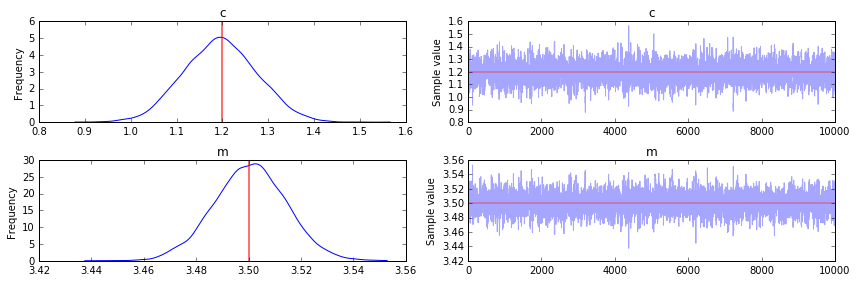

In [11]:
# plot trace output (overplot the true values)
_ = pm.traceplot(trace3, lines={'m': m, 'c': c})

# Using Student's $t$-likelihood

Here I'll do the same as above, but with a [Student's $t$-likelihood](http://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.StudentT).

logp = -125.54, ||grad|| = 481.5: 100%|██████████| 20/20 [00:00<00:00, 2528.44it/s]  
100%|██████████| 11000/11000 [00:09<00:00, 1143.76it/s]


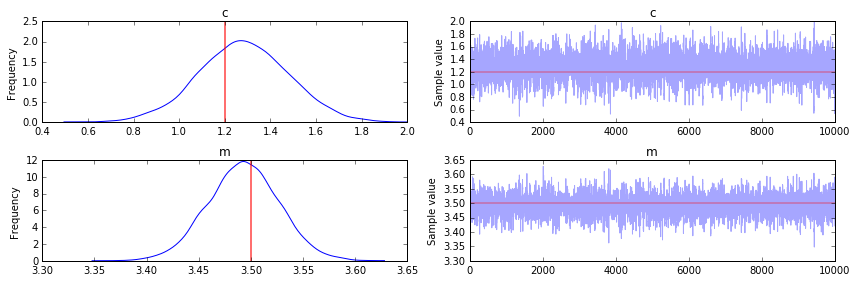

In [5]:
# set the PyMC3 model (this time have sigma a value for each data point)
linear_model_studentt = pm.Model()

with linear_model_studentt:
    # set priors for unknown parameters
    mmodel = pm.Uniform('m', lower=-10., upper=10.)         # uniform prior on gradient
    cmodel = pm.Normal('c', mu=0., sd=10.)                  # Gaussian prior on gradient
    
    # Expected value of outcome, aka "the model"
    mu = mmodel*x + cmodel
    
    # degrees of freedom (here do data length-1 to simulate a Student's-t derived from
    # a Gaussian where the standard deviation has been marginalised over with a Jeffrey's
    # prior rather than a uniform prior, for which nu=length)
    nu = len(y)-1
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.StudentT('Y_obs', nu=nu, mu=mu, observed=y)
    
# perform sampling
with linear_model_studentt:
    start4 = pm.find_MAP()  # Find starting value by optimization
    trace4 = pm.sample(10000, start=start4, tune=1000, discard_tuned_samples=True) # 10000 iterations, with 1000 iteration burn-in
    
# plot trace output (overplot the true values)
_ = pm.traceplot(trace4, lines={'m': m, 'c': c})